<a href="https://colab.research.google.com/github/MElena14/COMP341/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### imports

In [1]:
import random
import math
from collections import deque,namedtuple
import cv2
import pickle
from tqdm.notebook import tqdm
import PIL

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

import gym


#### Render OpenAI Gym Environments from CoLab

In [2]:
# HIDE OUTPUT
try:
    from google.colab import drive
    IN_COLAB = True
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
    env_name = "Atlantis-v0"
    !wget http://www.atarimania.com/roms/Roms.rar 
    !unrar x -o+ /content/Roms.rar >/dev/nul
    !python -m atari_py.import_roms /content/ROMS >/dev/nul

    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    !apt-get update > /dev/null 2>&1
    !apt-get install cmake > /dev/null 2>&1
    !pip install --upgrade setuptools 2>&1
    !pip install ez_setup > /dev/null 2>&1
    !pip install gym[atari] > /dev/null 2>&1
except:
    IN_COLAB = False
    env_name = "ALE/Atlantis-v5"
    print('not in colab')
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:1")
print("Using device", device)


--2022-04-20 15:36:48--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19583716 (19M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  18.68M   638KB/s    in 31s     

2022-04-20 15:37:19 (619 KB/s) - ‘Roms.rar’ saved [19583716/19583716]

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascie

Using device cuda:0


In [3]:
def query_environment(name):
  env = gym.make(name)
  spec = gym.spec(name)
  print(f"Action Space: {env.action_space}")
  print(f"possible actions: {env.unwrapped.get_action_meanings()}")
  print(f"Observation Space: {env.observation_space}")
  print(f"Max Episode Steps: {spec.max_episode_steps}")
  print(f"Nondeterministic: {spec.nondeterministic}")
  print(f"Reward Range: {env.reward_range}")
  print(f"Reward Threshold: {spec.reward_threshold}")
  
query_environment(env_name)

Action Space: Discrete(4)
possible actions: ['NOOP', 'FIRE', 'RIGHTFIRE', 'LEFTFIRE']
Observation Space: Box(0, 255, (210, 160, 3), uint8)
Max Episode Steps: 10000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None


In [6]:

import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

# display = Display(visible=0, size=(1400, 900))
# display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  print(mp4list[-1])
  if len(mp4list) > 0:
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

if IN_COLAB:
    from gym.wrappers import Monitor
    def wrap_env(env, record_every=1):
        env = Monitor(env, './video', force=True)
        return env
else:
    from gym.wrappers.record_video import RecordVideo
    def wrap_env(env, record_every=1):
        env = RecordVideo(env, './video', episode_trigger=lambda i: i % record_every == 0)
        return env


#### inital random agent

In [7]:
def show_random_agent():
  env = wrap_env(gym.make(env_name))

  observation = env.reset()
  score = 0
  while True:
      env.render()
      action = env.action_space.sample()
      observation, reward, done, info = env.step(action)
      score += reward
      if done:
        print(f"finished! random agent's score is {score}")
        break
  env.close()
  show_video()

#### Deep QN

In [8]:
class DQNCnn(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential( # in = 84x84
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        ) # out = 7x7
        self.feature_size = 7 * 7 * 64

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    

#### ResNetDQN

##### ResNetBlock

In [9]:
class ResNetBlock(nn.Module):
    def __init__(self, depth_in, activation_func, depth_out=-1):
        super().__init__()
        self.downSampleResidul = True
        if depth_out == -1:
            depth_out = depth_in
            self.downSampleResidul = False

        self.resBlock = nn.Sequential(
            nn.BatchNorm2d(depth_in),
            activation_func(inplace=True),
            nn.Conv2d(depth_in, depth_out, kernel_size=3, padding=1, stride=1 if not self.downSampleResidul else 2, bias=False),
            nn.BatchNorm2d(depth_out),
            activation_func(inplace=True),
            nn.Conv2d(depth_out, depth_out, kernel_size=3, padding=1, bias=False)
        )

        self.downsampleRes = nn.Sequential(
            nn.BatchNorm2d(depth_in),
            activation_func(inplace=True),
            nn.Conv2d(depth_in, depth_out, kernel_size=1, stride=2, bias=False)
        )

    def forward(self, x):
        z = self.resBlock(x)
        if self.downSampleResidul:
            x = self.downsampleRes(x)
        return z + x

In [10]:
def get_cnn_output_size(in_size, kernel_size, stride=1, padding=0):
    integer = int((in_size - kernel_size + 2 * padding) / stride) == ((in_size - kernel_size + 2 * padding) / stride)
    if not integer:
        print("not int", ((in_size - kernel_size + 2 * padding) / stride))
    return int((in_size - kernel_size + 2 * padding) / stride) + 1
get_cnn_output_size(in_size=20, kernel_size=3, stride=2, padding=1)

not int 9.5


10

##### ResNetDQN

In [11]:
class ResNetDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        self.input_shape = input_shape
        self.num_actions = num_actions
        super(ResNetDQN, self).__init__()
        #in = 159x159
        self.block1 = nn.Sequential(
            nn.Conv2d(input_shape[0], 16, kernel_size=3, stride=2, padding=0), #out = 79x79
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0), #out = 77x77
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0), #out = 75x75
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0) #out = 37x37
        )
        
        self.featureExtractionBlock = nn.Sequential(
            ResNetBlock(32, nn.SiLU, 64),  #out = 19x19
            ResNetBlock(64, nn.SiLU),      #out = 19x19
            ResNetBlock(64, nn.SiLU),      #out = 19x19 
            ResNetBlock(64, nn.SiLU, 128), #out = 10x10
            ResNetBlock(128, nn.SiLU),     #out = 10x10
        )
        # self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.flattened_size = 128 * 10 * 10
        self.regressionBlock = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.flattened_size, 1024),
            nn.Dropout(0.2),
            nn.SiLU(inplace=True),
            nn.Linear(1024, self.num_actions),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.featureExtractionBlock(x)
        # x = self.pool(x)
        x = x.view(-1, self.flattened_size)
        x = self.regressionBlock(x)
        return x

#### utils

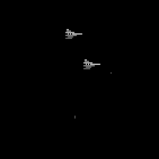

In [12]:
# taken from https://github.com/deepanshut041/Reinforcement-Learning/blob/master/algos/preprocessing/stack_frame.py
def preprocess_frame(screen, exclude, output):
    """Preprocess Image.
        
        Params
        ======
            screen (array): RGB Image
            exclude (tuple): Section to be croped (UP, RIGHT, DOWN, LEFT)
            output (int): Size of output image
        """
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    
    #Crop screen[Up: Down, Left: right] 
    screen = screen[exclude[0]:exclude[2], exclude[3]:exclude[1]]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    screen = cv2.resize(screen, (output, output), interpolation = cv2.INTER_AREA)
    return screen

def stack_frame(stacked_frames, frame, is_new):
    """Stacking Frames.
        
        Params
        ======
            stacked_frames (array): Four Channel Stacked Frame
            frame: Preprocessed Frame to be added
            is_new: Is the state First
        """
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

frame_crops = {'DQNcnn': 84, 'ResNetDQN': 159}

def get_stack_frames(net='DQNcnn'):
    size = frame_crops[net]
    def stack_frames(frames, state, is_new=False):
        frame = preprocess_frame(state, (0, -10, -100, 9), size)
        frames = stack_frame(frames, frame, is_new)
        return frames
    return stack_frames

def show_cropped_image():
    env = gym.make(env_name)
    observation = env.reset()
    t, done = 0, False
    while not done and t < 260:
      # env.render()
      action = env.action_space.sample() 
      observation, reward, done, info = env.step(action)
      
      t += 1
                                # (UP, RIGHT, DOWN, LEFT)
    f = preprocess_frame(observation, (0, -10, -100, 9), 159)
    return PIL.Image.fromarray(np.uint8(f * 255), mode="L")
show_cropped_image()

In [13]:
def plot_epsilon_func(eps_func, n_episodes=1000):
    episodes = range(n_episodes)
    eps = [eps_func(i) for i in episodes]
    plt.plot(episodes, eps)
    plt.show()

### memory

In [14]:
# Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
from numpy.typing import NDArray
class ReplayMemory:
    def __init__(self, buffer_size, batch_size, device, filename=None, topHalf=False):
        self.memory = deque(maxlen=buffer_size) if filename is None else pickle.load(open(filename, 'rb'))
        self.batch_size = batch_size*2 if topHalf else batch_size
        self.topHalf = topHalf
        self.device = device
        self.mean = lambda l: sum(l)/len(l)
    def add(self, state, action, reward, next_state, done):
        Experience = (state, action, reward, next_state, float(done))
        self.memory.append(Experience)
    def _as_tensor(self, np_array:NDArray, dtype=torch.float):
        tensor = torch.from_numpy(np.array(np_array))
        return tensor.type(dtype, non_blocking=True).to(self.device, non_blocking=True)
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        if self.topHalf:
            experiences.sort(key=lambda e:e[2])
            experiences = experiences[int(self.batch_size/2):self.batch_size-1]
            print(f"len={len(experiences)}")
        states, actions, rewards, next_states, dones = zip(*experiences)
        states, next_states = self._as_tensor(states), self._as_tensor(next_states)
        actions, rewards, dones = self._as_tensor(actions, dtype=torch.int64), self._as_tensor(rewards), self._as_tensor(dones, dtype=torch.uint8)
        return (states, actions, rewards, next_states, dones)
        

    def save(self, filename):
        pickle.dump(self.memory, open(filename, 'wb') )

    def __len__(self):
        return len(self.memory)

### Agent

In [15]:
class DQNAgent:
    def __init__(self, args):
        """
        args = {
            input_shape:  (tuple) dimension of each state (C, H, W)
            action_size (int): dimension of each action
            seed (int): random seed
            device(string): Use Gpu or CPU
            buffer_size (int): replay buffer size
            batch_size (int):  torch minibatch size
            gamma (float): discount factor
            lr (float): learning rate 
            update_every (int): how often to update the network
            replay_after (int): After which replay to be started
            model(Model): Pytorch Model
            base_filename (str): base filename to save models to
        }
        """
        self.input_shape = args['input_shape']
        self.action_size = args['action_size']
        self.device = args['device']
        self.buffer_size = args['buffer_size']
        self.batch_size = args['batch_size']
        self.gamma = args['gamma']
        self.lr = args['lr']
        self.learn_every = args['learn_every']
        self.replay_after = args['replay_after']
        self.network = args['model']
        self.tau = args['tau']
        self.base_filename = args['base_filename']

        
        # Q-Network
        self.policy_net = self.network(self.input_shape, self.action_size).to(self.device)
        self.target_net = self.network(self.input_shape, self.action_size).to(self.device)
        self.optimizer = torch.optim.AdamW(self.policy_net.parameters(), lr=self.lr, )
        
        self.memory = ReplayMemory(self.buffer_size, self.batch_size, self.device)
        
        self.time_step = 0

    def save(self):
        torch.save(self.policy_net.state_dict(), f"{self.base_filename}.policy.net")
        torch.save(self.target_net.state_dict(), f"{self.base_filename}.target.net")
        self.memory.save(f"{self.base_filename}.memory")

    def load(self):
        self.memory = ReplayMemory(self.buffer_size, self.batch_size, self.device, f"{self.base_filename}.memory")
        self.policy_net.load_state_dict(torch.load(f"{self.base_filename}.policy.net"))
        self.target_net.load_state_dict(torch.load(f"{self.base_filename}.target.net"))

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every "learn_every" time steps.
        self.time_step = (self.time_step + 1) % self.learn_every
        if self.time_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.replay_after:
                experiences = self.memory.sample()
                self.learn(experiences)


    def act(self, state, eps=0.):
        return actFunc(self.policy_net, state, self.device, eps)

    def act(self, state, eps=0.):
        if torch.rand(1).item() < eps: # Epsilon-greedy action selection
            return torch.randint(self.action_size, (1,)).item(), 2
        
        self.policy_net.eval() # set the model to evaluation mode
        with torch.no_grad():
            state = torch.from_numpy(state).unsqueeze(0).to(self.device)
            action_values = self.policy_net(state)
            action_selection = action_values.detach().argmax().cpu().numpy()
        self.policy_net.train() # set the model back to training mode
        return action_selection, 1
            
    def learn(self, experiences): #input = 1 mini-batch
        states, actions, rewards, next_states, dones = experiences

        # Get expected Q values from the policy, and max predicted Q values from the target
        Q_expected = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        targets_next = self.target_net(next_states).detach().max(dim=1)[0]
        
        # Calculate the Q value
        # Multiply by (1 - done) to zero out the next state Q values if the game ended.
        Q_targets = rewards + (self.gamma * targets_next * (1 - dones))
        
        # optimise the model, by minimising the loss
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.policy_net, self.target_net, self.tau)

    
    # θ'=θ×τ+θ'×(1−τ)
    def soft_update(self, policy_model, target_model, tau):
        for target_param, policy_param in zip(target_model.parameters(), policy_model.parameters()):
            target_param.data.copy_(tau*policy_param.data + (1.0-tau)*target_param.data)


# def actFunc(policy_net: nn.Module, state, device, eps=0.):
#     if torch.rand(1).item() < eps: # Epsilon-greedy action selection
#         return torch.randint(4, (1,)).item(), True
    
#     policy_net.eval() # set the model to evaluation mode
#     with torch.no_grad():
#         state = torch.from_numpy(state).unsqueeze(0).to(device)
#         action_values = policy_net(state)
#         action_selection = action_values.detach().argmax().cpu().numpy()
#     policy_net.train() # set the model back to training mode
#     return action_selection, False



### train

In [16]:
def epsilon_decrease_func(start, end, decay):
    def epsilon_decrease(i):
        return end + (start - end) * math.exp(-1. * i / decay)
    return epsilon_decrease

In [17]:
def trainDQN(agent, epsilon_decrease, n_episodes=1000, network='DQNcnn', start_epoch = 0, save_every=100, plot_every=500, log_eps=False):
    print(f"Training for {n_episodes} episodes, train every {agent.learn_every} episodes = {int(n_episodes/agent.learn_every)} train epoch")
    scores = []
    stack_frames = get_stack_frames(network)
    for i_episode in range(start_epoch + 1, start_epoch + n_episodes + 1):
        state = stack_frames(None, env.reset(), is_new=True)
        score, done = 0, False
        eps = epsilon_decrease(i_episode)
        if log_eps: actionTypes, actionTypesIdx = np.zeros(n_episodes*10, dtype=np.uint8), 0
        while not done:
            action, actionType = agent.act(state, eps)
            if log_eps:
                actionTypes[actionTypesIdx] = actionType
                actionTypesIdx += 1
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, is_new=False)
            agent.step(state, action, reward, next_state, done)
            state = next_state
        scores.append(score)
        log_eps_str = f'rand({round(np.count_nonzero(actionTypes[actionTypes == 2])/actionTypesIdx,2)}) nural({round(np.count_nonzero(actionTypes[actionTypes == 1])/actionTypesIdx,2)})    ' if log_eps else ""
        print(f'\rEpisode {i_episode}\tScore: {scores[-1]}\tAverage Score: {round(np.mean(scores[-20:]), 2)}\t eps:{round(eps, 2)}\t {log_eps_str}', end="")
        
        if i_episode % plot_every == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores[-50:])}')
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
        if i_episode % save_every == 0:
            agent.save()
    agent.save()
    return scores

### run train

In [18]:
model = 'ResNetDQN' # options are 'DQNcnn' or 'ResNetDQN'

Number_of_episodes = 8000
save_models_every = 250
train_every = 20

#### training runner

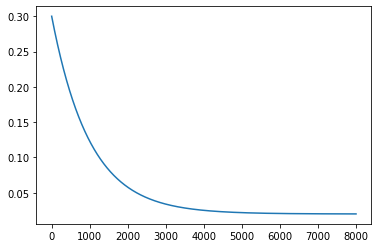

In [19]:
env = wrap_env(gym.make(env_name), record_every=1000)

agent_args = {
            'input_shape': (4, frame_crops[model], frame_crops[model]),
            'action_size': env.action_space.n,
            'device': device,
            'buffer_size': 100000,
            'batch_size': 64,
            'gamma': 0.99,
            'lr': 1e-4,
            'tau': 1e-3,
            'learn_every': train_every,
            'replay_after': 10000,
        }

if model == 'DQNcnn':
    agent_args = {**agent_args, 'model': DQNCnn, 'base_filename': 'atari_atlantas_models1'}
elif model == 'ResNetDQN':
    agent_args = {**agent_args, 'model': ResNetDQN, 'base_filename': 'atari_atlantas_resnet'}
else:
    raise Exception('model not found')

epsilon_decrease = epsilon_decrease_func(start=0.3, end=0.02, decay=Number_of_episodes/8)
# epsilon_decrease = lambda x: 0.000001
plot_epsilon_func(epsilon_decrease, Number_of_episodes)

#### Run

In [20]:
agent = DQNAgent(agent_args)
agent.load()
scores = trainDQN(agent, epsilon_decrease, n_episodes=Number_of_episodes, save_every=save_models_every, plot_every=1000, network=model)

FileNotFoundError: ignored

In [ ]:
_ = plt.hist(scores, bins=30)


In [ ]:
show_video()

In [ ]:
def finalPlay(agent):
    env = wrap_env(gym.make(env_name))
    score = 0
    state = stack_frames(None, env.reset(), True)
    while True:
        # env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        score += reward
        state = stack_frames(state, next_state)
        if done:
            print("You Final score is:", score)
            break 
    env.close()
finalPlay(agent)
show_video()

### DQN2

In [ ]:
class DQN2(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        print("in size", x.size())
        x = F.relu(self.bn1(self.conv1(x)))
        print("2 size", x.size())
        x = F.relu(self.bn2(self.conv2(x)))
        print("3 size", x.size())
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [ ]:
def get_output_size(in_size, kernel_size, stride=1, padding=0):
    integer = int((in_size - kernel_size + 2 * padding) / stride) == ((in_size - kernel_size + 2 * padding) / stride)
    if not integer:
        print("not int", ((in_size - kernel_size + 2 * padding) / stride))
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

get_output_size(in_size=84, kernel_size=3, stride=2, padding=0)

In [ ]:
class DQNtst(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions

        #in = 299x299
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=0), #out = 149x149
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0), #out = 147x147
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), #out = 147x147
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0) #out = 73x73                    
        )

        self.linear = nn.Sequential(
                  nn.Linear(state_space_dim,64),
                  nn.ReLU(),
                  nn.Linear(64,64*2),
                  nn.ReLU(),
                  nn.Linear(64*2,action_space_dim)
                )
# (33600x3 and 210x64)
    def forward(self, x):
        x = x.to(device)
        print('in size=', x.size())
        x = self.block1(x)
        print('block1 size=', x.size())
        return self.linear(x)

In [ ]:
class DQNCnn(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential( # in = 84x84
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        ) # out = 7x7
        self.feature_size = 7 * 7 * 64

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    